In [2]:
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install textblob
%pip install gensim
%pip install wordcloud
%pip install networkx
%pip install spacy
%pip install scikit-learn
%pip install pyLDAvis
%pip install pyLDAvis.gensim
%pip install pyLDAvis.gensim_models
%pip install pyLDAvis
%pip install pyLDAvis.gensim_models
%pip install pyLDAvis.gensim

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
#from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from gensim.matutils import sparse2full

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import networkx as nx
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import spacy

from collections import Counter

from gensim.corpora import Dictionary
from gensim.models import LdaModel

from wordcloud import WordCloud


# Unmount the drive
#drive.flush_and_unmount()
#print('Drive unmounted')





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached charset_normalizer-3.4.2-cp39-cp39-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3

/Users/filiporlikowski/Documents/MINITRI_Project_2 /.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **Load and Preprocess Data**

In [ ]:
name = "Counter_Strike"
# File path
#file_path = '/content/drive/My Drive/reviews_with_metadata.csv'
# Step 1: Load Data

data = pd.read_csv('/Users/filiporlikowski/Documents/MINITRI_Project_2 /MINITRI_Project_2/Scrapping/Counter_Strike_cleaned_reviews.csv')

# Step 2: Clean `Hours Played`
data['Hours Played'] = data['Hours Played'].replace(',', '', regex=True).astype(float)

# Step 3: Drop Rows with Missing Reviews
data = data.dropna(subset=['Review'])

# Step 4: Define Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace special characters with a space
    text = re.sub(r"[^\w\s]", " ", text)  # Keep only words and spaces
    # Replace numeric characters with a space
    text = re.sub(r"\d+", " ", text)
    # Remove non-ASCII and non-Cyrillic characters
    text = re.sub(r"[^\x00-\x7F\u0400-\u04FF\s]", " ", text)
    # Remove multiple consecutive spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize text
    tokens = word_tokenize(text)
    # Load stopwords and add custom stopwords
    custom_stopwords = set(stopwords.words('english'))
    custom_stopwords.update(['o', 'etc', 'would', 'could', 'us', 'the', 'to', 'of', 'in', 'it', 'and', 'this', 'that', 'for'])  # Add custom meaningless words
    # Remove stopwords and short tokens or stand-alone letters
    tokens = [word for word in tokens if word not in custom_stopwords and len(word) > 1]
    # Filter out stand-alone letters explicitly
    tokens = [word for word in tokens if len(word) > 1 or word.isnumeric()]
    # Join tokens back into a single string
    return ' '.join(tokens)


# Step 5: Apply Text Preprocessing
data['Processed_Review'] = data['Review'].apply(preprocess_text)

# Step 6: Drop Empty Processed Reviews
data = data[data['Processed_Review'].str.strip() != ""]

# Step 7: Convert `Date` Column to Datetime Format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.to_csv(f'{name}_cleaned_processed_reviews.csv')
# Display the first few rows of the processed data
data.head()


,Game,Date,Review,Hours Played,Recommendation,Helpful Votes,Processed_Review
0,730,2016-10-19,Where can I get the English version ?,2711.8,Recommended,7335,get english version
1,730,2020-11-02,The time I spent playing this game could've be...,1900.8,Recommended,2134,time spent playing game spent studying applyin...
2,730,2019-11-04,Underage Gambling,8154.3,Not Recommended,1806,underage gambling
3,730,2023-07-15,>see a guy >hit every shot >run out of bullets...,11.9,Recommended,905,see guy hit every shot run bullets turns aroun...
4,730,2023-08-14,>aim at corner >wait for enemy >turn away for ...,172.1,Recommended,918,aim corner wait enemy turn away seconds comes ...


# **Text Tokenization and Preparation**

In [66]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Step 8: Tokenize Processed Reviews
data['Tokenized_Review'] = data['Processed_Review'].apply(word_tokenize)

# Step 9: Build Vocabulary
def build_vocab_and_filter(data, min_word_freq=2):
    # Flatten all tokenized reviews to get all tokens
    all_tokens = [token for tokens in data['Tokenized_Review'] for token in tokens]
    vocab_counter = Counter(all_tokens)
    # Filter words by minimum frequency
    vocab = {word for word, count in vocab_counter.items() if count >= min_word_freq}
    return vocab

# Apply vocabulary filtering
min_word_freq = 2
vocab = build_vocab_and_filter(data, min_word_freq)

# Step 10: Filter Tokenized Reviews
data['Filtered_Review'] = data['Tokenized_Review'].apply(
    lambda tokens: [word for word in tokens if word in vocab]
)

# Step 11: Reconstruct Cleaned Documents
documents = data['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))

# Step 12: Prepare Metadata
metadata = data.drop(columns=['Review', 'Processed_Review', 'Tokenized_Review', 'Filtered_Review'])

# Step 13: Save Outputs (Optional)
documents.to_csv(f'processed_{name}_documents.csv', index=False, header=['Documents'])
metadata.to_csv(f'processed_{name}_metadata.csv', index=False)

# Step 14: Display Samples
print("Sample Processed Documents:")
print(documents.head())

print("\nVocabulary Size:", len(vocab))
print("Sample Vocabulary:", list(vocab)[:10])

print("\nSample Metadata:")
print(metadata.head())


Sample Processed Documents:
0                                  get english version
1    time spent playing game spent studying applyin...
2                                             gambling
3    see guy hit every shot run bullets turns aroun...
4    aim corner wait enemy turn away seconds comes ...
Name: Filtered_Review, dtype: object

Vocabulary Size: 2708
Sample Vocabulary: ['dodo', 'process', 'failure', 'spots', 'ruined', 'built', 'insomnia', 'hutchinson', 'opportunity', 'hahaha']

Sample Metadata:
   Game       Date  Hours Played   Recommendation  Helpful Votes
0   730 2016-10-19        2711.8      Recommended           7335
1   730 2020-11-02        1900.8      Recommended           2134
2   730 2019-11-04        8154.3  Not Recommended           1806
3   730 2023-07-15          11.9      Recommended            905
4   730 2023-08-14         172.1      Recommended            918


# **Sentiment Analysis**
Building World Clouds
Extracted key terms for each topic using labelTopics.
Visualized top words.
without date included

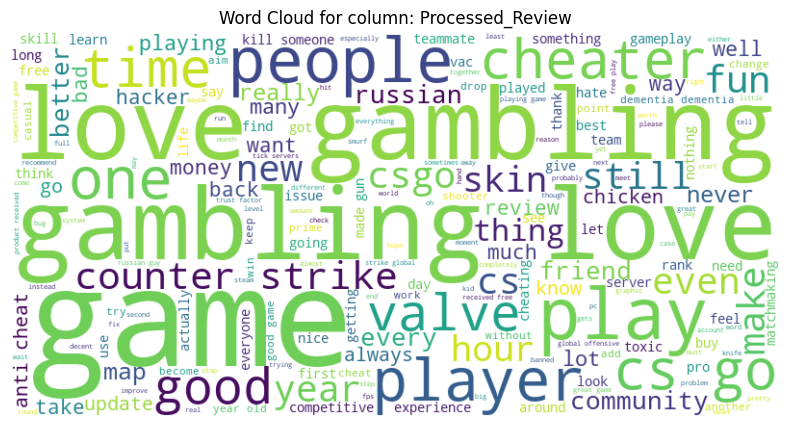

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/filiporlikowski/Documents/MINITRI_Project_2 /MINITRI_Project_2/Counter_Strike_cleaned_processed_reviews.csv')# Select the column with text (e.g., 'review_text')
text_column = 'Processed_Review'
text_data = data[text_column].dropna().astype(str).str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=True  # Avoid duplicate phrases
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for column: {text_column}')
plt.show()


In [ ]:
with dates included, before and after the update(change in the game from cs go to cs2)


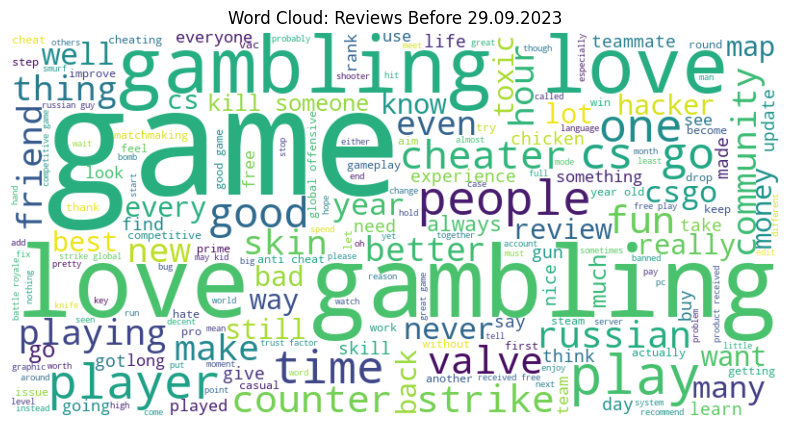

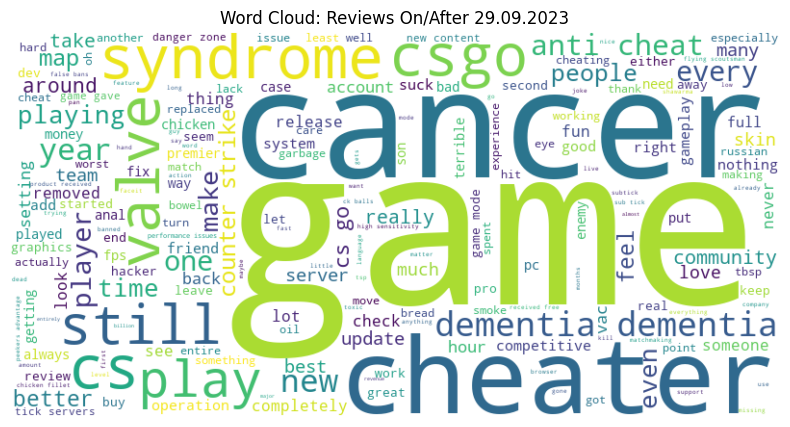

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load data

date = '2023-09-29'
# Convert 'date' column to datetime (adjust the column name if needed)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Split data into two periods
date_split = pd.Timestamp(date)
before_df = data[data['Date'] < date_split]
after_df = data[data['Date'] >= date_split]

text_column = 'Processed_Review'

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200,
        collocations=True
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Prepare text for each period
text_before = before_df[text_column].dropna().astype(str).str.cat(sep=' ')
text_after = after_df[text_column].dropna().astype(str).str.cat(sep=' ')

# Generate and show word clouds
generate_wordcloud(text_before, f'Word Cloud: Reviews Before {date}')
generate_wordcloud(text_after, f'Word Cloud: Reviews On/After {date}')


# **Word Frequencies**
without date included

         word  frequency
6        game        854
43       love        552
59   gambling        504
74         cs        267
0         get        245
285      play        235
75         go        212
112      like        189
70        one        182
56     people        171
201      good        158
3        time        156
282   someone        150
204  cheaters        148
376     valve        131
163   counter        120
117      team        118
317   players        117
5     playing        116
63      every        116


/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_13183/2262072920.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


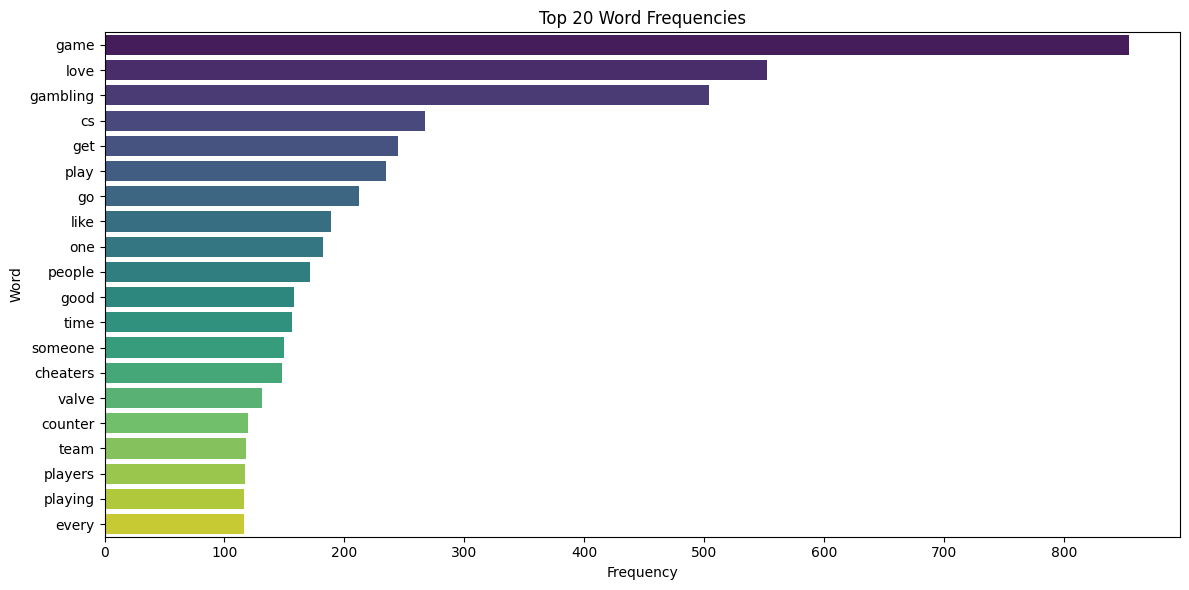

In [63]:
import pandas as pd
from collections import Counter
import re

# Select the column with text (e.g., 'review_text')
text_column = 'Processed_Review'  # Change to your actual column name
# Combine all text into one large string
all_text = ' '.join(data[text_column].dropna().astype(str).tolist())

# Basic cleaning: remove punctuation and make lowercase
cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())

# Tokenize
words = cleaned_text.split()

# Count word frequencies
word_freq = Counter(words)

# Convert to DataFrame and show top 20
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False)

print(freq_df.head(20))
freq_df = freq_df.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')
plt.title('Top 20 Word Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


In [ ]:
after and before update

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_13183/815706638.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


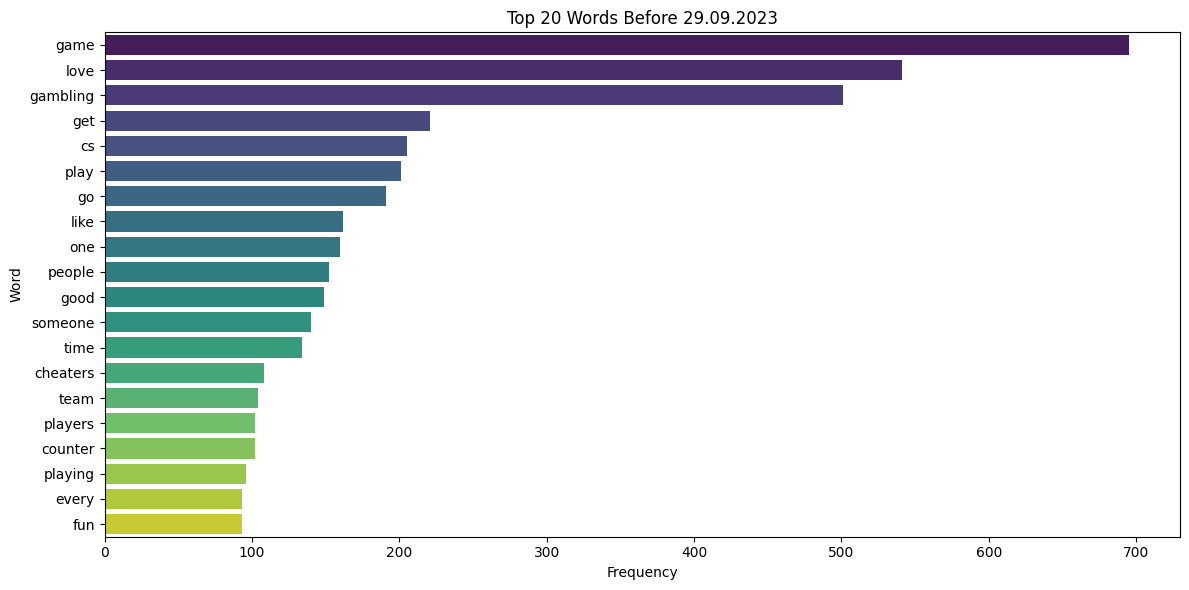

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_13183/815706638.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')


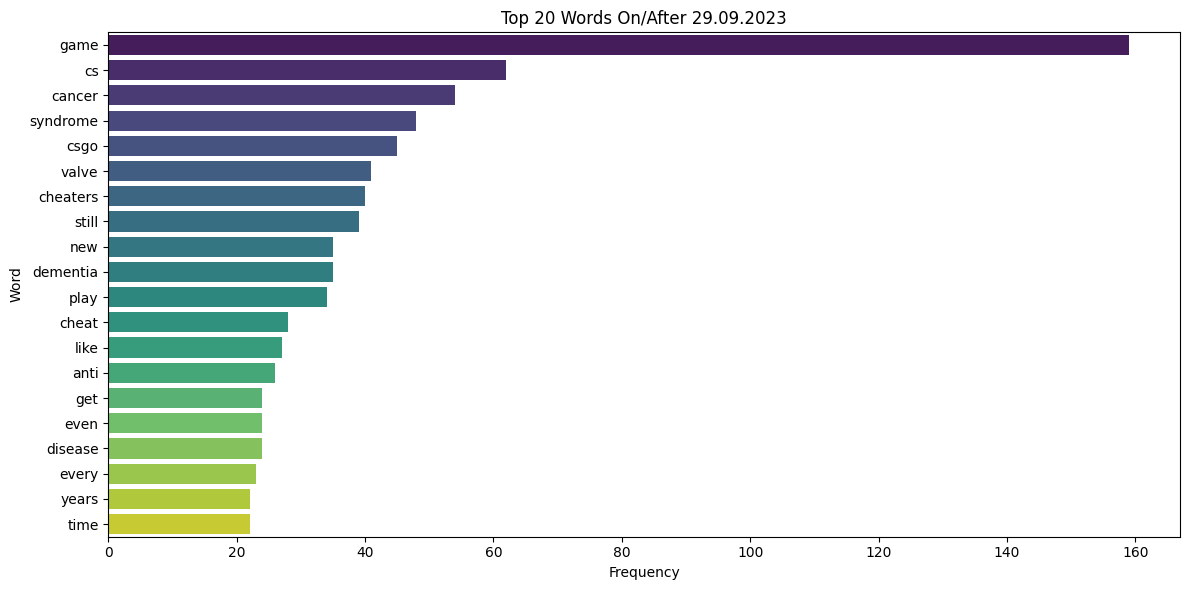

In [ ]:
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load data


# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # replace 'date' with your date column name

# Define date cutoff
cutoff_date = pd.Timestamp('date')

# Function to get top word frequencies and plot
def plot_top_words(df, text_col, title):
    all_text = ' '.join(df[text_col].dropna().astype(str).tolist())
    cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())
    words = cleaned_text.split()
    word_freq = Counter(words)
    freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
    freq_df = freq_df.sort_values(by='frequency', ascending=False).head(20)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='frequency', y='word', data=freq_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

# Filter data by date
before_df = data[data['Date'] < cutoff_date]
after_df = data[data['Date'] >= cutoff_date]

# Column with text
text_column = 'Processed_Review'  # Change if needed

# Plot word frequencies for each period
plot_top_words(before_df, text_column, f'Top 20 Words Before {date}')
plot_top_words(after_df, text_column, f'Top 20 Words On/After {date}')



# **Step 5: Sentiment Score and Sentiment Category Distribution**

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/filiporlikowski/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


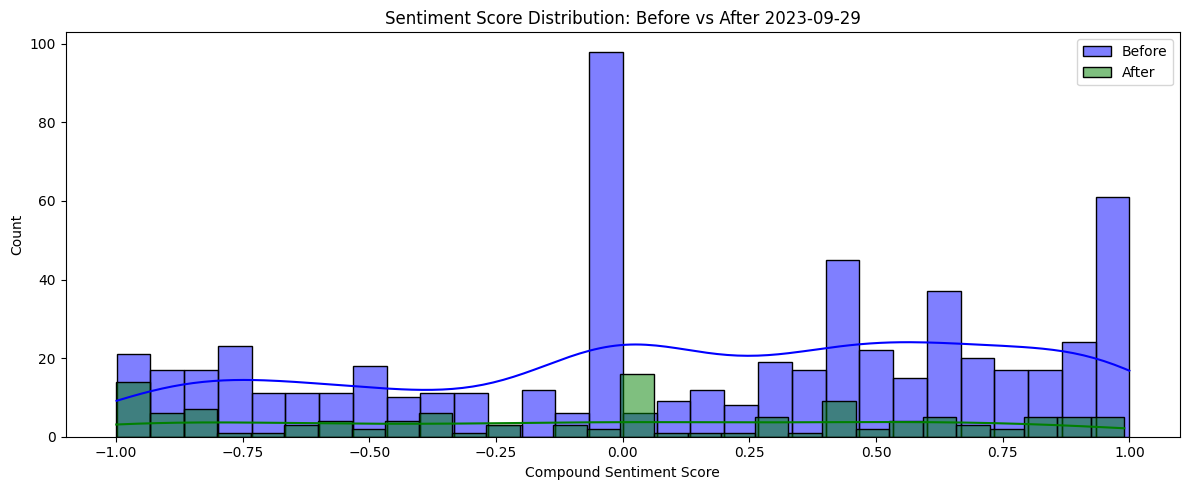

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_16396/4087386040.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=before_df, ax=axs[0], palette='Blues')
/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_16396/4087386040.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=after_df, ax=axs[1], palette='Greens')


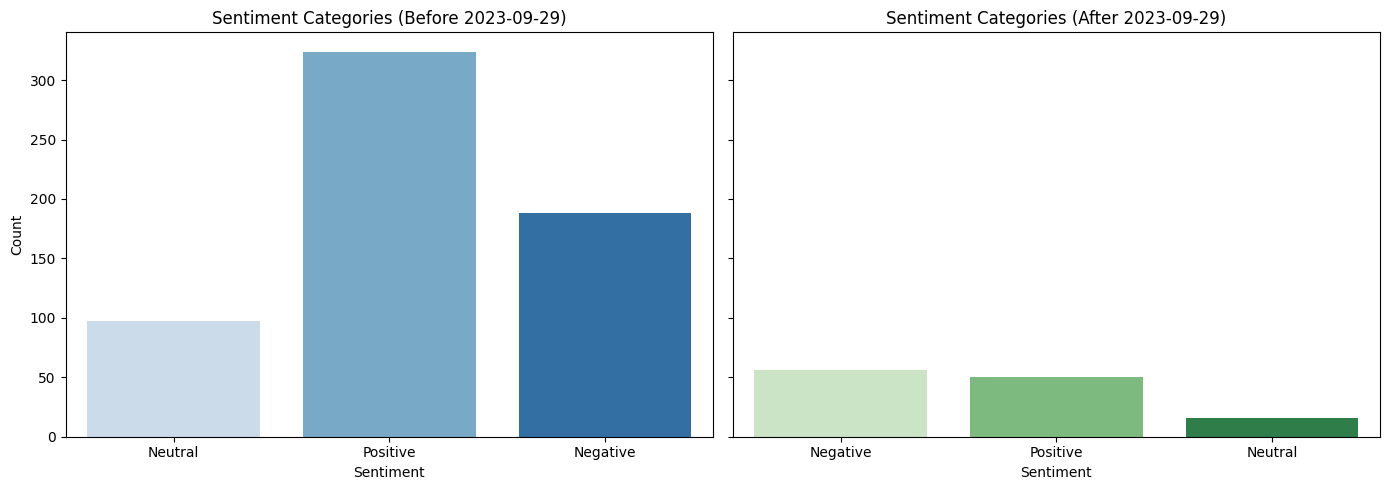

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER if not done already
nltk.download('vader_lexicon')



# Ensure date is datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop missing reviews
data = data.dropna(subset=['Processed_Review'])

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
data['sentiment_score'] = data['Processed_Review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize into sentiment classes
def get_sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(get_sentiment_category)

# Split before and after
cutoff = pd.Timestamp(date)
before_df = data[data['Date'] < cutoff]
after_df = data[data['Date'] >= cutoff]

# ---------- PLOT 1: Sentiment Score Distribution ----------
plt.figure(figsize=(12, 5))
sns.histplot(before_df['sentiment_score'], color='blue', kde=True, label='Before', bins=30)
sns.histplot(after_df['sentiment_score'], color='green', kde=True, label='After', bins=30)
plt.title(f'Sentiment Score Distribution: Before vs After {date}')
plt.xlabel('Compound Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- PLOT 2: Sentiment Category Counts ----------
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.countplot(x='sentiment_category', data=before_df, ax=axs[0], palette='Blues')
axs[0].set_title(f'Sentiment Categories (Before {date})')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')

sns.countplot(x='sentiment_category', data=after_df, ax=axs[1], palette='Greens')
axs[1].set_title(f'Sentiment Categories (After {date})')
axs[1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()


# **Step Sentiment vs user recommendation**
check if the sentiment alligns with whether the user recommendet the game or not.
Reccomended column is 2 variable one sentiment is a 3 variable one so we should not use a barplot like this one we should use a box plot to analyze sentiment score distribution by recommendation first, maybe that way we can assume that "Recommended" value can be also interpreted as neutral. Making sentiment score a 2 categorical variable.

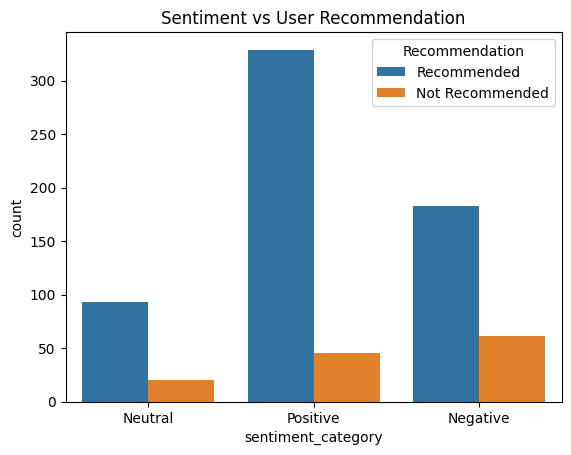

Number of NaN values in 'Recommendation': 0

Unique values and their counts in 'Recommendation':
Recommendation
Recommended        605
Not Recommended    126
Name: count, dtype: int64


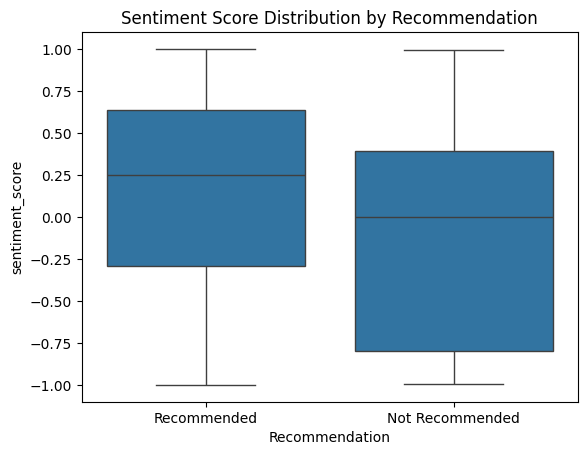

In [11]:
# Compare VADER sentiment to user's recommendation
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_category', hue='Recommendation', data=data)
plt.title('Sentiment vs User Recommendation')
plt.show()


# Check for NaN values
nan_count = data['Recommendation'].isna().sum()
print(f"Number of NaN values in 'Recommendation': {nan_count}")

# Show unique values and their counts
print("\nUnique values and their counts in 'Recommendation':")
print(data['Recommendation'].value_counts(dropna=False))  # includes NaNs

pd.crosstab(data['sentiment_category'], data['Recommendation'])
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data, x='Recommendation', y='sentiment_score')
plt.title("Sentiment Score Distribution by Recommendation")
plt.show()


In [ ]:
the median of sentiment score is possitive for the recommended category but close to being neutral, also bigger than 50% percentage of data falls into negative category, median of the sentiment score for not recommended category is close to 0, 50% of data present a negative sentiment score

# **how:Sentiment Score Recommendation Hours Played Helpful Votes all interact.**

Great! Using metadata like "Hours Played" and "Helpful Votes" can significantly enhance your sentiment analysis and recommendation understanding by offering context to the reviews.

🔍 Why Use Metadata?

"Hours Played" reflects user engagement — high hours + negative sentiment = possibly trusted criticism.
"Helpful Votes" reflect review quality/perceived value — high helpful votes = more influential opinion.
✅ Goals:

We'll analyze how:

Sentiment Score
Recommendation
Hours Played
Helpful Votes
…all interact.

Do highly engaged users (more hours) express more polarizing sentiment?
Are low helpful-vote reviews more neutral or noisy?
Do "Not Recommended" reviews with high helpful votes cluster differently than others?





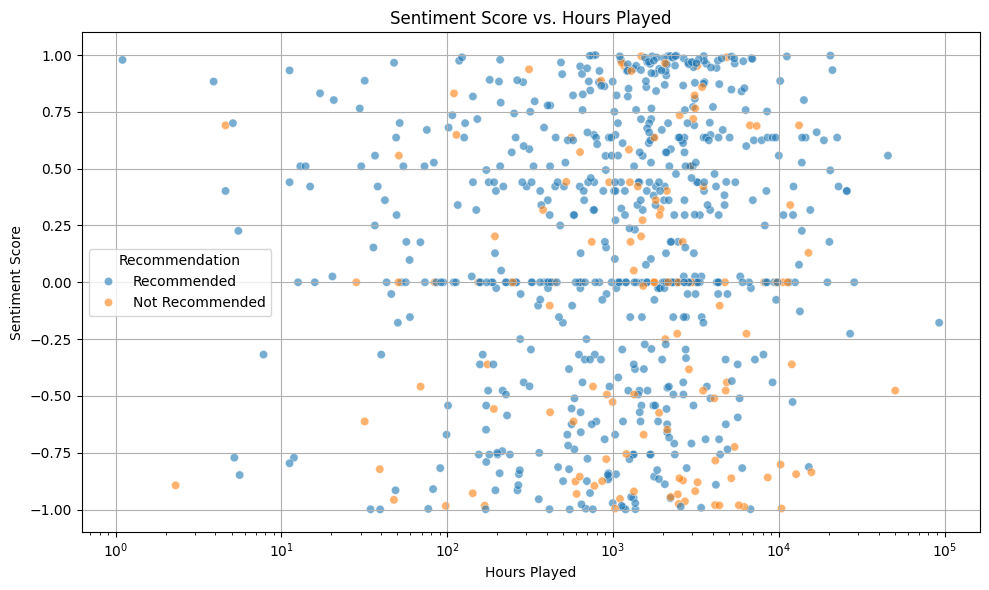

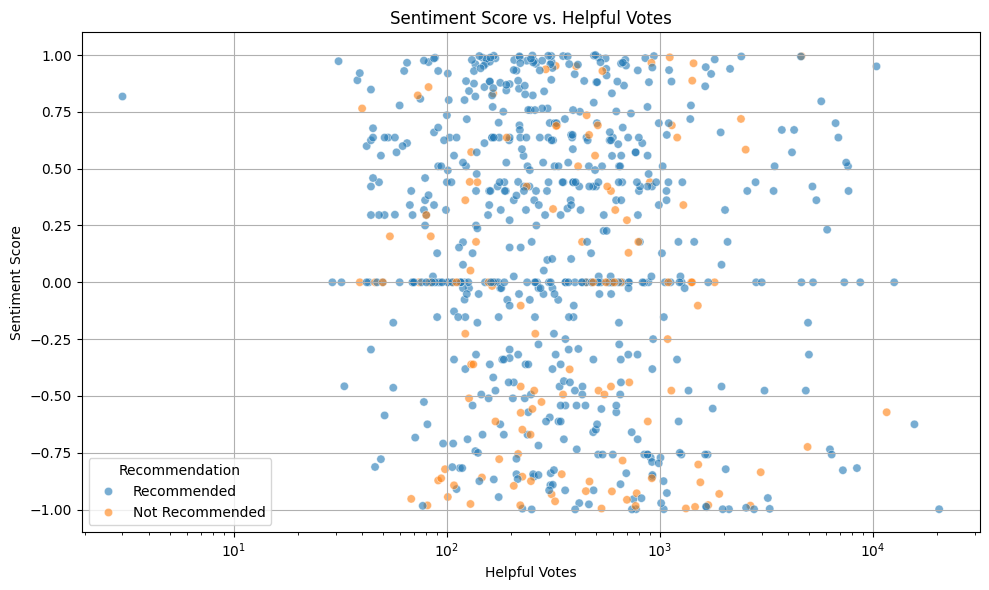

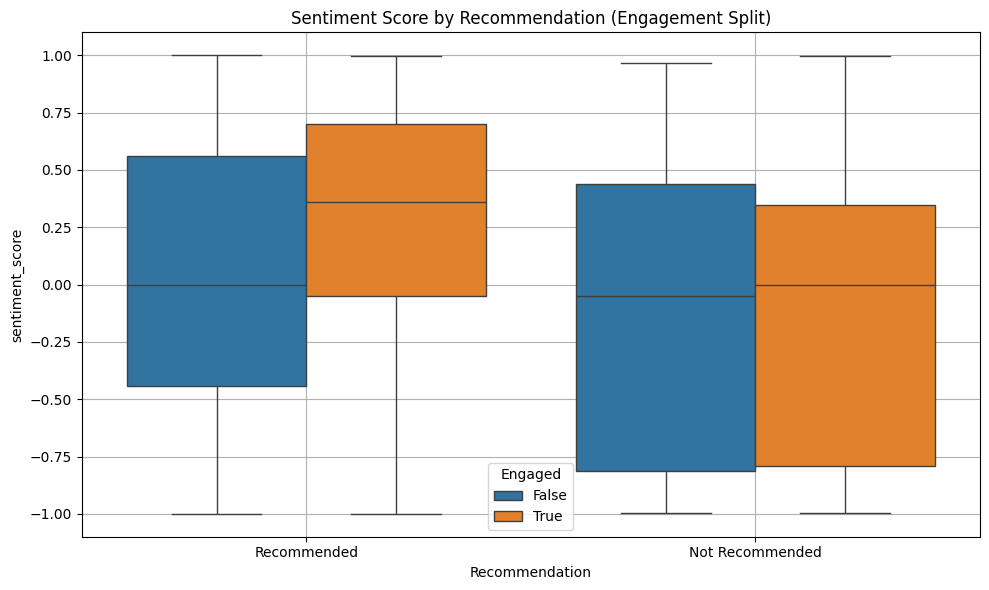

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = data.copy()

# Ensure types
df['Date'] = pd.to_datetime(df['Date'])
df['Hours Played'] = pd.to_numeric(df['Hours Played'], errors='coerce')
df['Helpful Votes'] = pd.to_numeric(df['Helpful Votes'], errors='coerce')
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')  # assuming you created this column

# Drop rows with missing critical values
df_clean = df.dropna(subset=['sentiment_score', 'Hours Played', 'Helpful Votes', 'Recommendation'])

# 1. Sentiment vs Hours Played
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Hours Played', y='sentiment_score', hue='Recommendation', alpha=0.6)
plt.title('Sentiment Score vs. Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Sentiment Score')
plt.xscale('log')  # if hours are skewed
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Sentiment vs Helpful Votes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Helpful Votes', y='sentiment_score', hue='Recommendation', alpha=0.6)
plt.title('Sentiment Score vs. Helpful Votes')
plt.xlabel('Helpful Votes')
plt.ylabel('Sentiment Score')
plt.xscale('log')  # optional: scale to handle outliers
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplot: Sentiment by Recommendation + engagement
df_clean['Engaged'] = df_clean['Hours Played'] > df_clean['Hours Played'].median()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Recommendation', y='sentiment_score', hue='Engaged')
plt.title('Sentiment Score by Recommendation (Engagement Split)')
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='sentiment_category', ylabel='Hours Played'>

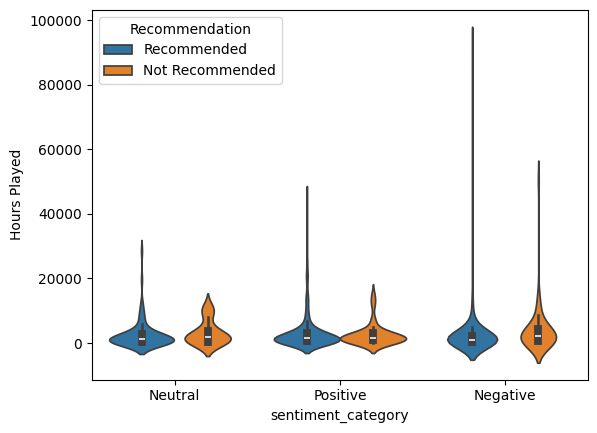

In [18]:
sns.violinplot(data=df_clean, x='sentiment_category', y='Hours Played', hue='Recommendation')


# **predictive model to explain recommendation based on metadata and sentiment?**

do we want to do it?